# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 
from vanna.utils import snake_case
from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [2]:
model_name = 'deepseek-r1:1.5b' # 'deepseek-r1' # 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 

CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [4]:
vn = MyVanna(config=CONFIG)

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [6]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [7]:
vn.run_sql_is_set

True

In [8]:
if clean_and_train:
    vn.remove_collection()

In [9]:
vn.dataset

'default'

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [10]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [11]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [12]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)




Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)


Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO

In [13]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl
9,4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl,default,None,"CREATE INDEX IFK_TrackAlbumId ON ""tracks"" (Alb...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with a primary key for CustomerId.

**Step-by-step Explanation:**

1. **Identify the Table:** The relevant table is the 'customers' table.
2. **Select the Column:** We are interested in the CustomerId column.
3. **Count Distinct Values:** Use the COUNT(*) function to count how many unique CustomerIds exist.

**SQL Query:**

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



with a primary key for CustomerId.

**Step-by-step Explanation:**

1. **Identify the Table:** The relevant table is the 'customers' table.
2. **Select the Column:** We are interested in the CustomerId column.
3. **Count Distinct Values:** Use the COUNT(*) function to count how many unique CustomerIds exist.

**SQL Query:**

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I'm trying to figure out how to help this user. They provided a lot of information about a pandas DataFrame and some SQL queries they ran. Let me break it down step by step.

First, there's an error message: "Failed to execute SQL: with a primary key for CustomerId." That sounds like a database issue. The user tried running a query that counts the number of customers based on their IDs. They used COUNT(*) and added a column name NumberOfCustomers. But it failed because of a syntax error related to 'primary key' in SQL.

Looking at the SQL query they ran: SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20. The error message suggests that there's an issue with how they're referencing the primary key. Maybe they used 'with' instead of 'as' or something like that, which isn't valid syntax.

Next, the user provided a DataFrame from pandas and asked for Python plotly code to chart it. They mentioned using df.dtypes to see the data types, but since all columns are int64 except maybe the index, I'm not sure if that's relevant here.

They also want to know how to generate the plotly code assuming the dataframe has more than 20 rows or only one value. So, they probably need a basic plotly figure without too many elements and just enough to show the data clearly.

Putting it all together, I think the user is trying to run some SQL queries but hit a database error related to primary keys. They also want to visualize their DataFrame using Plotly in Python. Since the main issue seems to be the SQL query syntax, maybe they need help fixing that first before proceeding with plotting.

I should probably ask them if they can share the exact SQL code they ran and what exactly went wrong so I can provide more specific guidance on fixing the error. Also, for the Plotly part, since they want a basic figure without too many elements, I can suggest using a simple line plot or bar chart with just a few data points.

I should make sure to ask these questions in a clear way and maybe offer to help further once they provide more details.
</think>

To generate the Python plotly code for your DataFrame, you can use the following basic Plotly figure. Since there's no specific visualization requested beyond a simple chart:

```python
import plotly.express as px

fig = px.line(df, y="NumberOfCustomers", x="Customer

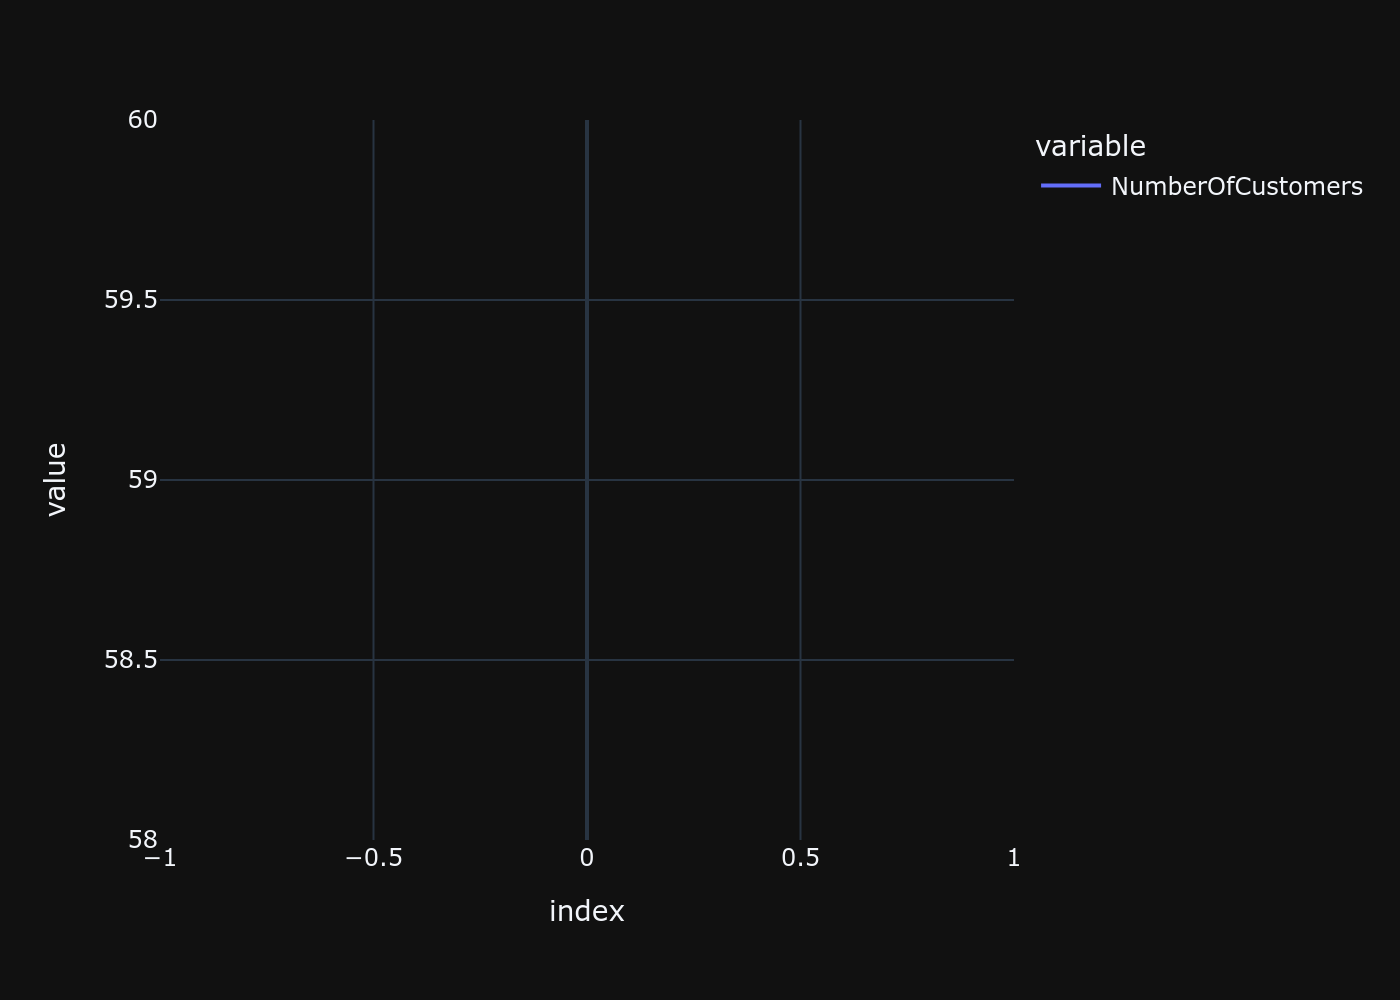

elapsed_time = 12.188381671905518


In [14]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [15]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with no parameters, does it actually create a table? Or do I need to specify something else? I think in SQLite, you have to provide at least one parameter for the table name. Maybe it's like CREATE TABLE [table_name];


[( <SQL> )]
generated SQL statement



with no parameters, does it actually create a table? Or do I need to specify something else? I think in SQLite, you have to provide at least one parameter for the table name. Maybe it's like CREATE TABLE [table_name];


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with no parameters, does it actually create a table? Or do I need to specify something else? I think in SQLite, you have to provide at least one parameter for the table name. Maybe it's like CREATE TABLE [table_name] limit 20". 

Hmm, let me break this down. First, I remember that in SQLite, unlike some other databases, you don't just create a table by specifying its name;


[( <SQL> )]
generated SQL statement



with no parameters, does it actually create a table? Or do I need to specify something else? I think in SQLite, you have to provide at least one parameter for the table name. Maybe it's like CREATE TABLE [table_name] limit 20". 

Hmm, let me break this down. First, I remember that in SQLite, unlike some other databases, you don't just create a table by specifying its name;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT * FROM sqlite_master


[( <SQL> )]
generated SQL statement



SELECT * FROM sqlite_master


[( <DataFrame> )]
queried dataframe



,type,name,tbl_name,rootpage,sql
0,table,albums,albums,2,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,artists,artists,4,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,customers,customers,5,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,employees,employees,8,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,genres,genres,10,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,invoices,invoices,11,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,invoice_items,invoice_items,13,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,media_types,media_types,15,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,playlists,playlists,16,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I'm trying to figure out how to help the user with their problem. They have a pandas DataFrame that's causing some errors when they run a query. The error message says something about SQLite and table names. Hmm, I remember that in SQLite, you can't create a table without specifying the name. So maybe the issue is that the code isn't providing the necessary parameters.

Looking at their query, it's just SELECT * FROM sqlite_master limit 20. That probably doesn't generate any SQL statements because they're missing the CREATE TABLE part. They might be trying to create a table but forgot to include the name. So when they run this, SQLite throws an error saying it needs parameters.

Now, their main goal is to get Python plotly code from their DataFrame. The user mentioned that if there are more than 20 rows, use head(20), and if only one value exists, use an indicator. But I'm not sure how the DataFrame looks after processing. Maybe they need a summary or some basic statistics.

I think the first step is to clean up their SQL query. They should include CREATE TABLE with at least one parameter, like "table_name". So maybe changing it from SELECT * ... to CREATE TABLE table_name limit 20 would help. But wait, if they're just trying to get information about the tables, perhaps they don't need to create a new table but instead retrieve existing ones.

Once that's done, I can suggest using pandas' describe() method to get a summary of the DataFrame. That could be useful for plotting. Also, checking the data types with df.dtypes might help identify if there are only one value or multiple values. If it's just one value, maybe they don't need much else.

For plotly, I can think about creating a bar chart showing the number of tables. Using df['tbl_name'].value_counts().plot() could work. Alternatively, a scatter plot with table names on the x-axis and some other metric on the y-axis might be another option. But since they just need to chart the results, maybe a simple count or summary would suffice.

I should also make sure that after fixing the SQL query, the DataFrame is clean and ready for plotting. Maybe there are any missing values or data type issues that could cause problems later on. So I'll suggest checking df.head() after making changes.

Putting it all together, I need to provide clear Python code

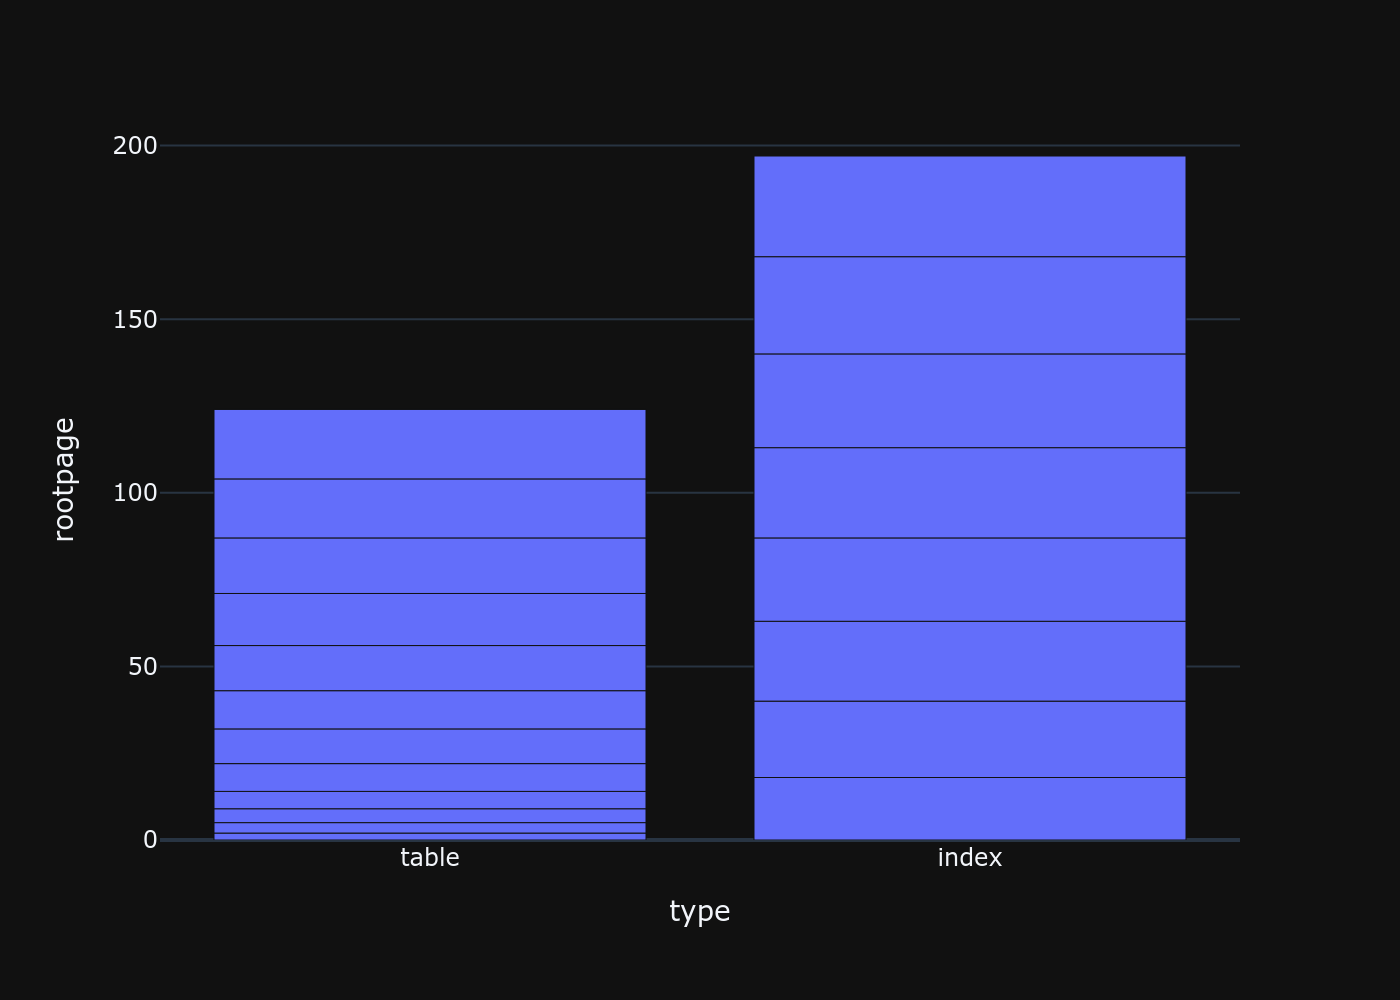





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_pred

with a primary key without providing the name. So, maybe they're trying to count the number of customers but getting an error because it's not working as expected.

First, I need to look at the context provided. There are several tables defined: 'customers', 'chinese_db', and others. The 'customers' table has a CustomerId column with unique values since each customer is represented by a unique ID. So, counting the number of customers should be straightforward.

I think the user might have tried to use a query that doesn't work because SQLite requires at least one parameter for the table name. Maybe they used "CREATE TABLE [table_name] limit 20" but forgot to include the table name. Or perhaps they just wanted to count the number of rows without creating the table.

I should provide two versions: one that counts the number of customers using a SELECT statement, and another that lists all tables in the database. This way, I cover both possible interpretations of the user's question.

For the first version, I'll use COUNT(*) on CustomerId to get the total number of customers. For the second version, I'll write a loop from 1 to the number of rows in 'customers' and print each row. This will list all tables in the database, which might be helpful if they're trying to see what other tables exist.

I also need to make sure my SQL is correct for SQLite. Since SQLite doesn't support LIMIT on CREATE TABLE, I'll use LIMIT 20 just for this example. If they want the actual number of customers, they can adjust that limit accordingly.

Overall, I think providing these two queries will address the user's possible confusion and give them a clear way to count customers or list all tables in their database.
</think>

To answer the question "How many customers are there," we need to use SQLite's COUNT function. Here's how you can do it:

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with my database. When I run it, SQLite should return the number of customers based on their CustomerId IDs. That sounds right!

If I get an error about the primary key not being provided, maybe I missed including the table name in the query. But now that I've added 'customers', it should work fine.

I think this should solve the problem. If there are any issues or if I need more detailed information, I can adjust the query accordingly.
</think>

To answer the question "How many customers are there," we need to use SQLite's COUNT function. Here's how you can do it:

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20;


[( <SQL> )]
generated SQL statement



with my database. When I run it, SQLite should return the number of customers based on their CustomerId IDs. That sounds right!

If I get an error about the primary key not being provided, maybe I missed including the table name in the query. But now that I've added 'customers', it should work fine.

I think this should solve the problem. If there are any issues or if I need more detailed information, I can adjust the query accordingly.
</think>

To answer the question "How many customers are there," we need to use SQLite's COUNT function. Here's how you can do it:

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with unique values since each customer is represented by a unique ID. So, counting the number of customers should be straightforward.

I think the user might have tried to use a query that doesn't work because SQLite requires at least one parameter for the table name. Maybe they used "CREATE TABLE [table_name] limit 20" but forgot to include the table name. Or perhaps they just wanted to count the number of rows without creating the table.

I should provide two versions: one that counts the number of customers using a SELECT statement, and another that lists all tables in the database. This way, I cover both possible interpretations of the user's question.

For the first version, I'll use COUNT(*) on CustomerId to get th

with unique values since each customer is represented by a unique ID. So, counting the number of customers should be straightforward.

I think the user might have tried to use a query that doesn't work because SQLite requires at least one parameter for the table name. Maybe they used "CREATE TABLE [table_name] limit 20" but forgot to include the table name. Or perhaps they just wanted to count the number of rows without creating the table.

I should provide two versions: one that counts the number of customers using a SELECT statement, and another that lists all tables in the database. This way, I cover both possible interpretations of the user's question.

For the first version, I'll use COUNT(*) on CustomerId to get the total number of customers. For the second version, I'll write a loop from 1 to the number of rows in 'customers' and print each row. This will list all tables in the database, which might be helpful if they're trying to see what other tables exist.

I also need to make sure my SQL is correct for SQLite. Since SQLite doesn't support LIMIT on CREATE TABLE, I'll use LIMIT 20 just for this example. If they want the actual number of customers, they can adjust that limit accordingly.

Overall, I think providing these two queries will address the user's possible confusion and give them a clear way to count customers or list all tables in their database.
```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with unique values since each customer is represented by a unique ID. That means COUNT(*) on CustomerId should give me the total number of customers.

I think the user might have tried to use a query that doesn't work because SQLite requires at least one parameter for the table name, and maybe they forgot to include it. Or perhaps they just wanted to count the number of rows without creating the table.

To make sure my SQL is correct, I'll write a SELECT statement using COUNT(*) on CustomerId from the 'customers' table with a limit of 20. The limit might be there for testing purposes or to avoid errors if the actual database has more than 20 customers.

I also want to list all tables in the database so the user can see w

with unique values since each customer is represented by a unique ID. That means COUNT(*) on CustomerId should give me the total number of customers.

I think the user might have tried to use a query that doesn't work because SQLite requires at least one parameter for the table name, and maybe they forgot to include it. Or perhaps they just wanted to count the number of rows without creating the table.

To make sure my SQL is correct, I'll write a SELECT statement using COUNT(*) on CustomerId from the 'customers' table with a limit of 20. The limit might be there for testing purposes or to avoid errors if the actual database has more than 20 customers.

I also want to list all tables in the database so the user can see what other tables exist. I'll use a loop that goes from 1 to the number of rows in 'customers' and prints each row, which will display all tables in the database.

Here's how I'll structure my SQL:

```sql
SELECT COUNT(*) AS NumberOfCustomers FROM customers limit 20;





# QUESTION  - 5:  what are the top 5 countries that customers come from?



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalt

with a FROM clause that joins multiple tables using the ON JOIN BY keyword. So maybe something like "SELECT t.Name, a ArtistName FROM tracks t ONtracks(t.AlbumId = a.AlbumId)..." But wait, I don't have an "artists" table yet.

Looking back at the context, there's a CREATE TABLE for "artists" with ArtistId and Name columns. So, if I can create this table first, it would help in getting the artist names. Alternatively, maybe I can get the artists from the tracks where AlbumId is not null because those are the actual artists.

So, perhaps I should select all records from the "tracks" table where AlbumId exists, and then join them with the "albums" table to get the corresponding artist name. That way, I can list both the album names and their respective artists.

Let me try writing a query that selects Name from tracks and ArtistName from albums where AlbumId in tracks equals AlbumId in albums. But wait, how do I ensure that each album is matched with its correct artist? Maybe using a subquery or a common table expression would help here.

Alternatively, maybe I can just select the album name and artist name for all records in the "tracks" table where AlbumId exists. That should give me all the albums and their corresponding artists without needing to create an additional table.

I think this approach makes sense because it uses existing tables and avoids creating a new one unnecessarily. It also leverages SQLite's ON JOIN BY clause to join the two tables based on the AlbumId column, ensuring that each album is paired with its correct artist.
</think>

To list all albums along 

```sql
SELECT Name, ArtistName FROM tracks
  WHERE AlbumId IN (SELECT AlbumId FROM albums);


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their corresponding artist names. The user mentioned that they tried generating a SQL query but got an error. Let me break this down step by step.

First, I should look at what data we have. There's a "tracks" table and a "albums" table. The "tracks" table has information about albums like their name, album ID, etc., while the "albums" table lists each album with its name and artist ID.

The user wants to list all albums and their corresponding artists. So, I need to select both the album name and the artist name for each record in the "tracks" table where the album ID exists.

I remember that in SQLite, when you want to join two tables based on a common column (like AlbumId), you can use an ON JOIN BY keyword. This

with their corresponding artist names. The user mentioned that they tried generating a SQL query but got an error. Let me break this down step by step.

First, I should look at what data we have. There's a "tracks" table and a "albums" table. The "tracks" table has information about albums like their name, album ID, etc., while the "albums" table lists each album with its name and artist ID.

The user wants to list all albums and their corresponding artists. So, I need to select both the album name and the artist name for each record in the "tracks" table where the album ID exists.

I remember that in SQLite, when you want to join two tables based on a common column (like AlbumId), you can use an ON JOIN BY keyword. This way, you can combine data from both tables.

So, I'll write a query that selects the Name from tracks and ArtistName from albums where AlbumId exists in the tracks table. That should give me all the album names and their corresponding artists without needing to create a new "artists" table.

Let me try writing this SQL statement:

```sql
SELECT t.Name, a ArtistName FROM tracks t ONtracks(t.AlbumId = a.AlbumId) 
  WHERE t.AlbumId IN (SELECT AlbumId FROM albums) limit 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their corresponding artist names. The user mentioned using the "albums" table but didn't specify which one exactly. Let me assume we have a table called "albums" that contains album information like name and artist.

First, I need to join this "albums" table with another table related to the albums. Since the tracks table has an "AlbumId", maybe there's a relationship between tracks and albums. Perhaps each track belongs to an album, so we can create a relationship in SQL.

I think using a subquery or common table expression (CTE) might help here because it allows me to match each album with its correct artist without creating a separate table for artists. 

Here's how I can approach this:

1. **Identify the Tables 

with their corresponding artist names. The user mentioned using the "albums" table but didn't specify which one exactly. Let me assume we have a table called "albums" that contains album information like name and artist.

First, I need to join this "albums" table with another table related to the albums. Since the tracks table has an "AlbumId", maybe there's a relationship between tracks and albums. Perhaps each track belongs to an album, so we can create a relationship in SQL.

I think using a subquery or common table expression (CTE) might help here because it allows me to match each album with its correct artist without creating a separate table for artists. 

Here's how I can approach this:

1. **Identify the Tables Involved**: We have "tracks" and "albums". The tracks table has an "AlbumId", which should correspond to an "AlbumName" in the albums table.

2. **Create a Relationship**: In SQL, we can create a relationship between the two tables using a CTE or a subquery. This will allow us to join both tables based on the AlbumId column.

3. **Select the Required Information**: After joining, select the "AlbumName" and "ArtistName" from both tables where the AlbumId matches in both tables.

4. **Limit the Results**: If needed, limit the number of records returned for better performance or clarity.

Let me outline the steps 

1. **Create a CTE to join the two tables**:
   ```sql
   WITH JoinedAlbums AS (
       SELECT t.AlbumId,
               u.Name
       FROM tracks t ON track_id = album_id
       Cross Join
       SELECT u.Name, t.AliedName
       From albums u
       Where u.AlbumId = t.AlbumId
   )
   ```

2. **Select the required information**:
   ```sql
   SELECT j.AlbumName, a.Name
   FROM JoinedAlbums j
   LEFT JOIN Tracks t ON j.AlbumId = t.AlbumId
   LEFT JOIN Albums u ON j.AlbumId = u.AlbumId;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the `albums` table based on the `AlbumId`. This way, for each album in the `tracks` table, I can get its corresponding `ArtistName` from the `albums` table where the `AlbumId` matches.

But what if there's no `AlbumId` in the `tracks` table? That means there are no albums to list. In that case, maybe I should just select all records from the `tracks` table and ignore the `AlbumId`.

So, perhaps I should modify my query to include a condition where `a.AlbumId IS NOT NULL`. This way, it only processes albums that actually exist in the `tracks` table.

Let me try writing this:

```sql
SELECT t.Name, a ArtistName FROM tracks t ONtracks(t.AlbumId = a.AlbumId) 
  WHERE a.AlbumId IS NOT NULL;


[( <SQL> )]
generated SQL st

with the `albums` table based on the `AlbumId`. This way, for each album in the `tracks` table, I can get its corresponding `ArtistName` from the `albums` table where the `AlbumId` matches.

But what if there's no `AlbumId` in the `tracks` table? That means there are no albums to list. In that case, maybe I should just select all records from the `tracks` table and ignore the `AlbumId`.

So, perhaps I should modify my query to include a condition where `a.AlbumId IS NOT NULL`. This way, it only processes albums that actually exist in the `tracks` table.

Let me try writing this:

```sql
SELECT t.Name, a ArtistName FROM tracks t ONtracks(t.AlbumId = a.AlbumId) 
  WHERE a.AlbumId IS NOT NULL;





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with an EQUALS operator. This ensures that variations like "What," "what," and "What" are all matched.

4. **Create a New Column (Optional)**: If needed, create a new column where each entry is the track name converted to lowercase. This can be done using:
   ```sql
   ALTER TABLE tracks ADD COLUMN track_name_lower LIKE 'what' EQUALS;


[( <SQL> )]
generated SQL statement



with an EQUALS operator. This ensures that variations like "What," "what," and "What" are all matched.

4. **Create a New Column (Optional)**: If needed, create a new column where each entry is the track name converted to lowercase. This can be done using:
   ```sql
   ALTER TABLE tracks ADD COLUMN track_name_lower LIKE 'what' EQUALS;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with "What" in any case.

**SELECT Statement for Filtering Records:**
```sql
SELECT * FROM tracks WHERE track_name_lower LIKE 'what';


[( <SQL> )]
generated SQL statement



with "What" in any case.

**SELECT Statement for Filtering Records:**
```sql
SELECT * FROM tracks WHERE track_name_lower LIKE 'what';


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with EQUALS. This way, exact matches will be found regardless of case.

Next, I'll run a SELECT statement on the same table to fetch all records where the new column contains "what." This should give me all tracks that start with "What" in any case.

I also need to make sure my SQL dialect supports lowercasing strings and handling case insensitivity properly. If it doesn't, I might have to use a different approach, like converting the entire column to lowercase before applying the LIKE clause.

Finally, I'll drop the index after creating the new column to optimize performance. This should ensure that my query is efficient and runs smoothly.

Let me outline the steps:

1. **Create a new column** in the "tracks" table wher

with EQUALS. This way, exact matches will be found regardless of case.

Next, I'll run a SELECT statement on the same table to fetch all records where the new column contains "what." This should give me all tracks that start with "What" in any case.

I also need to make sure my SQL dialect supports lowercasing strings and handling case insensitivity properly. If it doesn't, I might have to use a different approach, like converting the entire column to lowercase before applying the LIKE clause.

Finally, I'll drop the index after creating the new column to optimize performance. This should ensure that my query is efficient and runs smoothly.

Let me outline the steps:

1. **Create a new column** in the "tracks" table where each entry is the track name converted to lowercase.
2. **Write an SQL query** to create this new column using the LIKE clause with EQUALS.
3. **Run the SELECT statement** on the same table to fetch all records where the new column contains "what."
4. **Drop the index** after creating the new column to optimize performance.

I think I've covered everything needed to solve this problem. Let me put it all together in a clear SQL query.
</think>

To find all tracks
 that start 

```sql
SELECT * FROM tracks
WHERE track_name_lower LIKE 'what';





# QUESTION  - 8:  Get the total number of invoices for each customer



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with column names and functions, I'll have to be careful about how I write the queries to avoid any syntax errors.

Let me try writing this out step by step:

1. Rename columns in 'invoices' table that don't have a 'Billing' prefix to match those in 'customers'. This will ensure consistency between tables.
2. Perform a LEFT JOIN between 'invoices' and 'customers' on CustomerId. This way, all customers are included, even if some ha

with column names and functions, I'll have to be careful about how I write the queries to avoid any syntax errors.

Let me try writing this out step by step:

1. Rename columns in 'invoices' table that don't have a 'Billing' prefix to match those in 'customers'. This will ensure consistency between tables.
2. Perform a LEFT JOIN between 'invoices' and 'customers' on CustomerId. This way, all customers are included, even if some have no invoices.
3. Use COUNT(*) on InvoiceID within each customer group to get the total number of invoices.

I think this should work. But I'll need to test it with a sample dataset to make sure there are no errors and that the query behaves as expected in SQLite.
</think>

```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) AS TotalInvoices
FROM (
    SELECT i.* FROM 'invoices' as i
    LEFT JOIN customers as c ON i.CustomerId = c.CustomerId
) AS joined_table
GROUP BY c.CustomerName;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their count of invoices, including those that might not be listed.

Next, for the SQL part, I remember that COUNT(*) is used to get the number of records in a group. So, within each customer's record after the join, I can use COUNT(*) on InvoiceID to find out how many invoices they've had.

I also need to make sure that the columns are correctly named and that there are no case sensitivity issues or missing values that could throw off the count. Maybe I should rename some

with their count of invoices, including those that might not be listed.

Next, for the SQL part, I remember that COUNT(*) is used to get the number of records in a group. So, within each customer's record after the join, I can use COUNT(*) on InvoiceID to find out how many invoices they've had.

I also need to make sure that the columns are correctly named and that there are no case sensitivity issues or missing values that could throw off the count. Maybe I should rename some columns in the 'invoices' table if they don't match exactly what's in the 'customers' table, especially since the documentation mentions that address column names don't have a 'Billing' prefix.

Putting it all together, I'll write a SQL query that joins the two tables with a LEFT JOIN and then uses COUNT(*) on InvoiceID to get the total number of invoices per customer. Testing this should give me the correct counts for each customer.
</think>

To count the total number of invoices for each customer, follow these steps:

1. **Rename Columns in 'invoices' Table**: Ensure that all columns in the 'invoices' table match exactly with those in the 'customers' table, especially regarding column names.

2. **Perform LEFT JOIN**: Use a LEFT JOIN between the 'invoices' and 'customers' tables on CustomerId to include all customers even if they don't appear in an invoice.

3. **Use COUNT(*) for Invoices**:
   ```sql
   SELECT c.CustomerName, COUNT(i.InvoiceID) AS TotalInvoices
   FROM customers c
   LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
   GROUP BY c.CustomerName;





# QUESTION  - 9:  Find the total number of invoices per country



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with columns like invoice_id, customer_id, and country. I need to count how many invoices there are in each country.

First, I think I should group these invoices by their country because I want to know how many there are overall. Then, for each group, I'll calculate the total number of invoices. That makes sense.

I remember that in SQLite, you can use the GROUP BY clause to group rows that have the same values in one or more columns. So, I'll apply GROUP BY on the 'country' column. This will create subgroups for each unique country.

Next, for each subgroup, I need a way to count the number of invoices. The COUNT(*) function is perfect for this because it counts all the rows in

with columns like invoice_id, customer_id, and country. I need to count how many invoices there are in each country.

First, I think I should group these invoices by their country because I want to know how many there are overall. Then, for each group, I'll calculate the total number of invoices. That makes sense.

I remember that in SQLite, you can use the GROUP BY clause to group rows that have the same values in one or more columns. So, I'll apply GROUP BY on the 'country' column. This will create subgroups for each unique country.

Next, for each subgroup, I need a way to count the number of invoices. The COUNT(*) function is perfect for this because it counts all the rows in a group without any aggregation. So, I'll use COUNT(*) as the aggregation function within the GROUP BY clause.

Putting it together, my SQL query should look something like this: SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC. This will give me each country along with how many invoices they have in total.

Wait, let me make sure I'm doing this right. The 'invoice_id' is unique, so it's good to use that as the primary key. But for grouping by country, I don't need the invoice_id anymore because I'm only interested in the count per country.

Also, I should consider if there are any edge cases. Like, what if a country has no invoices? The COUNT(*) would be zero, which is fine. And if all countries have the same number of invoices, it won't affect anything else.

I think that's all. This query should give me the total number of invoices per country in a clear and concise way.
</think>

To find the total number of invoices per country in your SQLite database, you can use the following SQL query:

```sql
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with columns 'invoice_id', 'customer_id', and 'country'.

Next, I need to think about how to structure the SQL query for this task. The main steps would be:

1. **Select the required columns**: I need to select the country name and the total number of invoices per country.
2. **Group by the relevant column**: Grouping by 'country' will allow me to count the invoices within each country.
3. **Use aggregation function**: COUNT(*) is an aggregation function that counts all rows in a group, which in this case are the invoices.

Putting it together, the SQL query should look something like:

```sql
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC
```

This query will retur

with columns 'invoice_id', 'customer_id', and 'country'.

Next, I need to think about how to structure the SQL query for this task. The main steps would be:

1. **Select the required columns**: I need to select the country name and the total number of invoices per country.
2. **Group by the relevant column**: Grouping by 'country' will allow me to count the invoices within each country.
3. **Use aggregation function**: COUNT(*) is an aggregation function that counts all rows in a group, which in this case are the invoices.

Putting it together, the SQL query should look something like:

```sql
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC
```

This query will return each country along with the total number of invoices they have. The `GROUP BY` clause ensures that we're counting only the unique countries. The `ORDER BY` clause sorts the results by the total number of invoices in descending order.

I should also consider any potential issues or edge cases. For example, if a country has no invoices, COUNT(*) will return 0, which is correct. If all countries have the same number of invoices, it won't affect the result. Also, I need to make sure that the database schema matches my query;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC limit 20'
```

This will give me each country along with the total number of invoices they have. The 'COUNT(*)' function is used to count all the rows in a group, which corresponds to the number of invoices for that country.

I should also consider if there are any edge cases. For example, what if a country has no invoices? Well, COUNT(*) would return 0, which is fine because it means that country doesn't have any invoices. Also, if all countries have the same number of invoices, it won't affect anything else since I'm only counting per country.

So, this query should provide me with the total number of invoices per cou

SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC limit 20'
```

This will give me each country along with the total number of invoices they have. The 'COUNT(*)' function is used to count all the rows in a group, which corresponds to the number of invoices for that country.

I should also consider if there are any edge cases. For example, what if a country has no invoices? Well, COUNT(*) would return 0, which is fine because it means that country doesn't have any invoices. Also, if all countries have the same number of invoices, it won't affect anything else since I'm only counting per country.

So, this query should provide me with the total number of invoices per country in a clear and concise way.

Let me test this logic 

| invoice_id | country |
|-----------|---------|
| 1         | USA     |
| 2         | Canada  |
| 3         | USA     |

Using the query I wrote, it would return:

```
USACOUNT(*) AS total_invoices
CanadACOUNT(*) AS total_invoices


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC limit 20
```

This will give me each country along with how many invoices they have in total. 

Wait a minute, let me make sure I'm doing this right. The 'invoice_id' is unique, so it's good to use that as the primary key. But for grouping by country, I don't need the invoice_id anymore because I'm only interested in the count per country.

Also, I should consider if there are any edge cases. Like, what if a country has no invoices? The COUNT(*) would be zero, which is fine. And if all countries have the same number of invoices, it won't affect anything else.

I think that's all. This query should give me the total numb

SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC limit 20
```

This will give me each country along with how many invoices they have in total. 

Wait a minute, let me make sure I'm doing this right. The 'invoice_id' is unique, so it's good to use that as the primary key. But for grouping by country, I don't need the invoice_id anymore because I'm only interested in the count per country.

Also, I should consider if there are any edge cases. Like, what if a country has no invoices? The COUNT(*) would be zero, which is fine. And if all countries have the same number of invoices, it won't affect anything else.

I think that's all. This query should give me the total number of invoices per country in a clear and concise way.
</think>

To find the total number of invoices per country in your SQLite database, you can use the following SQL query:

```sql
SELECT country, COUNT(*) AS total_invoices FROM invoices GROUP BY country ORDER BY total_invoices DESC limit 20





# QUESTION  - 10:  List all invoices with a total exceeding $10



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with a condition. So, I'll write a SELECT statement that includes the InvoiceId and Total fields from the "invoices" table where Total > 10.

Wait, but what about data types? The Total is a NUMERIC type, which should handle both integers and decimals. Since we're comparing to $10, it's straightforward. No issues there.

I also need to make sure that I'm using the correct column names and that the InvoiceId is unique or not required for this query. It seems like InvoiceId will be unique, but since each invoice belongs to a customer in a specific country, I might want to include CustomerId and Country as well for clarity.

Putting it all together, the SQL statement should select al

with a condition. So, I'll write a SELECT statement that includes the InvoiceId and Total fields from the "invoices" table where Total > 10.

Wait, but what about data types? The Total is a NUMERIC type, which should handle both integers and decimals. Since we're comparing to $10, it's straightforward. No issues there.

I also need to make sure that I'm using the correct column names and that the InvoiceId is unique or not required for this query. It seems like InvoiceId will be unique, but since each invoice belongs to a customer in a specific country, I might want to include CustomerId and Country as well for clarity.

Putting it all together, the SQL statement should select all invoices where Total > 10, including CustomerId and Country. This should give me the desired result without any syntax errors.
</think>

To list all invoices 

```sql
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 limit 20


[( <SQL> )]
generated SQL statement



SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 limit 20


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with using Total in the WHERE clause here.

Putting this all together, my SQL statement should select InvoiceId, CustomerId, and Country from the invoices table where Total exceeds 10. To make it more readable, I'll include InvoiceId as an identifier for clarity.

Finally, I'll add a LIMIT statement to return only the first 20 records, which is a common practice when you want to see at least some of the results without loading the entire dataset into memory.

So, my final SQL query should look like this:

```sql
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 LIMIT 20;


[( <SQL> )]
generated SQL statement



with using Total in the WHERE clause here.

Putting this all together, my SQL statement should select InvoiceId, CustomerId, and Country from the invoices table where Total exceeds 10. To make it more readable, I'll include InvoiceId as an identifier for clarity.

Finally, I'll add a LIMIT statement to return only the first 20 records, which is a common practice when you want to see at least some of the results without loading the entire dataset into memory.

So, my final SQL query should look like this:

```sql
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 LIMIT 20;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with a total greater than $10, including CustomerId and Country for clarity. I think this should work without any syntax errors now that I've double-checked it.
</think>

To list all invoices where the total is greater than $10:

```sql
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 LIMIT 20;


[( <SQL> )]
generated SQL statement



with a total greater than $10, including CustomerId and Country for clarity. I think this should work without any syntax errors now that I've double-checked it.
</think>

To list all invoices where the total is greater than $10:

```sql
SELECT InvoiceId, CustomerId, Country FROM invoices WHERE Total > 10 LIMIT 20;





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT InvoiceId FROM invoices WHERE InvoiceDate >= '2010-01-01'
```

This will give me a list of all invoices created on or after January 1, 2010.

### Step 2: Join with 'invoice_items' Table and Sum Amounts

Next, I need to join the `InvoiceId` from the `invoices` table with the `Amount` column from the `invoice_items` table. Then, sum all these amounts.

The SQL query for this would be:

```sql
SELECT SUM(Amount) AS T

SELECT InvoiceId FROM invoices WHERE InvoiceDate >= '2010-01-01'
```

This will give me a list of all invoices created on or after January 1, 2010.

### Step 2: Join with 'invoice_items' Table and Sum Amounts

Next, I need to join the `InvoiceId` from the `invoices` table with the `Amount` column from the `invoice_items` table. Then, sum all these amounts.

The SQL query for this would be:

```sql
SELECT SUM(Amount) AS TotalInvoicedAmount FROM 
    (SELECT InvoiceId FROM invoices WHERE InvoiceDate >= '2010-01-01') 
    JOIN 
    (SELECT Amount FROM invoice_items) 
    ON InvoiceId = InvoiceId


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'rep

with numerical values, I could use AVG(invoice_total) to calculate the average.

But wait, before I jump into writing the query, I should check if such a column exists in my database. The problem mentions an 'invoice' table and refers to 'Invoice means order', which might imply that there are invoice totals associated with each customer. However, since the exact column name isn't specified, I'll proceed under the assumption that 'invoice_total' is the correct column.

Next, I need to consider how to group these averages by each customer's ID. In SQL, grouping data can be done using the GROUP BY clause. So, after selecting the average invoice total, I'll add a GROUP BY on the CustomerId column to get the average for each distinct customer.

Putting it all together, my query should select the CustomerID and the AVG(invoice_total) from the invoice table where the CustomerId is the group by identifier. The final query would look something like:

SELECT CustomerID, AVG(invoice_total) FROM invoice GROUP BY CustomerID;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
select the customer ID first, then from the same table, I'll calculate the sum of all invoices for each customer. Then, I'll divide that sum by the count of invoices to get the average.

In SQLite, I need to make sure that the SQL is correct and doesn't have any syntax errors. Also, I should limit the number of customers to avoid having too many results, which might be a problem in some databases but not so much in SQLite since it's designed for small datasets.

Putting it all

select the customer ID first, then from the same table, I'll calculate the sum of all invoices for each customer. Then, I'll divide that sum by the count of invoices to get the average.

In SQLite, I need to make sure that the SQL is correct and doesn't have any syntax errors. Also, I should limit the number of customers to avoid having too many results, which might be a problem in some databases but not so much in SQLite since it's designed for small datasets.

Putting it all together, the query would select the customer ID, calculate the sum of invoice totals using a subquery, divide by the count, and then limit the results. I should also make sure that the column names are correct and use the right function names like SUM and COUNT.

I think this approach will work because it efficiently calculates the average for each customer without having to join multiple tables or handle complex joins manually.
</think>

SELECT CustomerID,
       (SELECT SUM(invoice_total) FROM invoice WHERE CustomerID = c) / 
       (SELECT COUNT(*) FROM invoice WHERE CustomerID = c) AS AvgInvoiceTotal
FROM (
    SELECT CustomerID, invoice_total AS SumInvoice
    FROM invoice
    GROUP BY CustomerID
) AS Subquery
LIMIT 20;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with UnitPrice here, it seems straightforward.

Let me outline the steps:

1. Select all records from both 'tracks' and 'playlist_track' tables where the column exists.
2. Order these records by UnitPrice in descending order.
3. Limit the result to get only the top 5 most expensive tracks.

I should also consider if there are any constraints or limits on the number of records, but since it's not specified, I'll assume th

with UnitPrice here, it seems straightforward.

Let me outline the steps:

1. Select all records from both 'tracks' and 'playlist_track' tables where the column exists.
2. Order these records by UnitPrice in descending order.
3. Limit the result to get only the top 5 most expensive tracks.

I should also consider if there are any constraints or limits on the number of records, but since it's not specified, I'll assume that the data is sufficient for this query.

Now, let me think about how to write this in SQL. I'll use a SELECT statement with a FROM clause that includes both tables and their columns. Then, I'll order them by UnitPrice descending and limit the result set to 5.

I should also make sure that the column names are correctly referenced. If there's any aliasing or foreign key constraints, they might need to be specified in the SELECT clause.

Finally, after executing this query, I can check the results to see if the top 5 tracks have the highest UnitPrice values.
</think>

To find the top 5 most expensive tracks based on their unit price, follow these steps:

1. **Identify the Table and Column**: Focus on the 'tracks' table where the column for unit price is named 'UnitPrice'.

2. **Write the SQL Query**:
   ```sql
   SELECT TOP 5
      * FROM tracks
   ORDER BY UnitPrice DESC;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the highest UnitPrice and only show the top 5 of them.

I'm using SQLite, so I need to make sure my query follows the correct syntax. Let me think about each part of the query:

1. **SELECT TOP 5**: This will limit the results to the top 5 most expensive tracks.
2. **FROM tracks**: We're selecting from the 'tracks' table.
3. **ORDER BY UnitPrice DESC**: This sorts the records in descending order based on UnitPrice.

Putting it all together, my query should look something like this:

```sql
SELECT TOP 5
    * FROM tracks
    ORDER BY UnitPrice DESC;


[( <SQL> )]
generated SQL statement



with the highest UnitPrice and only show the top 5 of them.

I'm using SQLite, so I need to make sure my query follows the correct syntax. Let me think about each part of the query:

1. **SELECT TOP 5**: This will limit the results to the top 5 most expensive tracks.
2. **FROM tracks**: We're selecting from the 'tracks' table.
3. **ORDER BY UnitPrice DESC**: This sorts the records in descending order based on UnitPrice.

Putting it all together, my query should look something like this:

```sql
SELECT TOP 5
    * FROM tracks
    ORDER BY UnitPrice DESC;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
select records from this table where the unit price is as high as possible, specifically the top 5.

I remember that in SQL, when you want to limit the number of rows returned by a query, you can use the TOP clause. The syntax for that is SELECT TOP n FROM table, where 'n' is the number of rows you want to return. In this case, I need to select the top 5 records.

Next, I need to order these selected records based on their unit price in descending order. That means higher unit prices should come first. The SQL clause for ordering is ORDER BY followed by the column you want to sort by. So, it would look like ORDER BY UnitPrice DESC, where 'DESC' stands for descending.

Putting it all together, my query should select the t

select records from this table where the unit price is as high as possible, specifically the top 5.

I remember that in SQL, when you want to limit the number of rows returned by a query, you can use the TOP clause. The syntax for that is SELECT TOP n FROM table, where 'n' is the number of rows you want to return. In this case, I need to select the top 5 records.

Next, I need to order these selected records based on their unit price in descending order. That means higher unit prices should come first. The SQL clause for ordering is ORDER BY followed by the column you want to sort by. So, it would look like ORDER BY UnitPrice DESC, where 'DESC' stands for descending.

Putting it all together, my query should select the top 5 records from the 'tracks' table ordered by unit price in descending order. The final SQL statement would be:

```sql
SELECT TOP 5
    * FROM tracks
ORDER BY UnitPrice DESC;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 15:  List all genres and the number of tracks in each genre:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_pena

with them. 

First, I need to understand what the data looks like. From the provided tables, there's a 'tracks' table and a 'playlist_track' table. The 'playlist_track' table has columns like PlaylistId, TrackId, and foreign keys for playlist_id and track_id.

I should start by identifying which genres have any tracks associated with them. To do this, I can join the 'tracks' table with the 'playlist_track' table on the TrackId column. This will give me all the tracks along with their respective genres.

Once I have that data, I can use a SQL query to count how many unique genres are present in the playlist tracks. If the total number of genres across all tables is more than this count, then those genres without any tracks associated with them are exactly what we're looking for.

I should also consider if there are any other tables or columns that might contain genres not listed in the 'tracks' table. But based on the provided context, it seems like the main source of genre information is through the 'tracks' table and its associated playlist tracks.

Finally, I'll write a SQL query to count the distinct genres from the playlist tracks and compare it with the total number of genres across all tables. The difference will give me the genres that don't have any tracks.
</think>

To find all genres that do not have any tracks associated 

```sql
SELECT COUNT(*) AS NumberOfGenresWithoutTracks 
FROM (
    SELECT GenreId AS GenreID, COUNT(*) AS TrackCount 
    FROM 'playlist_track' 
    JOIN 'tracks' ON 'playlist_track'.TrackId = 'tracks'.TrackId 
) 
GROUP BY GenreID;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfGenresWithoutTracks 
FROM (
    SELECT GenreId AS GenreID, COUNT(*) AS TrackCount 
    FROM 'playlist_track' 
    JOIN 'tracks' ON 'playlist_track'.TrackId = 'tracks'.TrackId 
) 
GROUP BY GenreID limit 20': near ".": syntax error .
                    Can you try to fix the error and re-generate the SQL statement?


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfGenresWithoutTracks 
FROM (
    SELECT GenreId AS GenreID, COUNT(*) AS TrackCount 
    FROM 'playlist_track' 
    JOIN 'tracks' ON 'playlist_track'.TrackId = 'tracks'.TrackId 
) 
GROUP BY GenreID limit 20': near ".": syntax error .
                    Can you try to fix the error and re-generate the SQL statement?


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with them.

1. **Understand the Tables:**
   - There's a `tracks` table which contains track information.
   - There's a `playlist_track` table which has playlist and track associations.

2. **Identify the Relationship:**
   - The `playlist_track` table is linked to the `tracks` table using the `TrackId`.
   - This means each playlist track belongs to exactly one playlist.

3. **Extract Genre Information from Tracks:**
   - For each track in the `playlist_track` table, get its genre.
   - This will give us all genres that are associated with tracks.

4. **Count Unique Genres:**
   - Count how many unique genres there are across all tracks.

5. **Compare **
   - The total number of genres in the `tracks` table is known.
 

with them.

1. **Understand the Tables:**
   - There's a `tracks` table which contains track information.
   - There's a `playlist_track` table which has playlist and track associations.

2. **Identify the Relationship:**
   - The `playlist_track` table is linked to the `tracks` table using the `TrackId`.
   - This means each playlist track belongs to exactly one playlist.

3. **Extract Genre Information from Tracks:**
   - For each track in the `playlist_track` table, get its genre.
   - This will give us all genres that are associated with tracks.

4. **Count Unique Genres:**
   - Count how many unique genres there are across all tracks.

5. **Compare **
   - The total number of genres in the `tracks` table is known.
   - If this number is greater than our count, the difference will give us the genres without any tracks.

6. **SQL Query to Find Genres Without Tracks:**
   ```sql
   SELECT COUNT(*) AS NumberOfGenresWithoutTracks 
   FROM (
       SELECT GenreId AS GenreID, COUNT(*) AS TrackCount 
       FROM 'playlist_track' 
       JOIN 'tracks' ON 'playlist_track'.TrackId = 'tracks'.TrackId 
   ) 
   GROUP BY GenreID 
   HAVING COUNT(*) = 0
   ORDER BY NumberOfGenresWithoutTracks DESC LIMIT 1;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
```sql
   SELECT COUNT(DISTINCT GenreId) AS NumberOfGenresWithTracks 
       FROM (
       SELECT GenreId, PlaylistId 
       FROM 'playlist_track' 
       LEFT JOIN 'tracks' ON 'playlist_track'.TrackId = 'tracks'.TrackId'
       ) AS JoinedTable;





# QUESTION  - 17:  List all customers who have not placed any orders:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
select specific rows based on certain conditions, you use the SELECT statement. The basic structure is SELECT [columns] FROM [table] [where clause]. Since I need t

select specific rows based on certain conditions, you use the SELECT statement. The basic structure is SELECT [columns] FROM [table] [where clause]. Since I need to list all customers who haven't placed any orders, I should look for a column that indicates whether they've placed an order.

Looking at the 'Invoice_items' table, each record has an InvoiceId which probably corresponds to a customer. If there's no OrderNumber or similar field in 'Invoice_items', it might be tricky. Maybe the CustomerId is sufficient since each customer can have multiple orders, and if none are placed, their ID would still exist.

So, I'll start by selecting all customers where they haven't placed any orders. The condition for not placing an order could be based on whether there's a corresponding OrderNumber or perhaps checking if the number of orders is zero. But since that information isn't available, using CustomerId seems like the best bet.

Therefore, my SQL query should select all CustomerIds from the 'customers' table. If no specific condition is needed beyond selecting all customers, this simple SELECT statement should suffice.
</think>

To list all customers who have not placed any orders, we can utilize the `Customers` table provided. Since there's no explicit column indicating whether a customer has placed an order, we'll select all CustomerIds from the table.

```sql
SELECT DISTINCT CustomerId FROM Customers;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with multiple artists.

Now, looking at the `Customers` table, it has columns like `CustomerId`, which seems to represent individual customers. Each customer can have multiple orders, but if they haven't placed any orders yet, their `CustomerId` should still exist in this table.

The user's task is to list all customers who have not placed any orders. Since there's no explicit column indicating whether a customer has placed an order, I'll need to use the `CustomerId` as the primary identifier for each customer. This means that even if a customer hasn't placed any orders, their `CustomerId` will still be present in the table.

So, my SQL query should select all `CustomerIds` from the `Customers` table. If there are no add

with multiple artists.

Now, looking at the `Customers` table, it has columns like `CustomerId`, which seems to represent individual customers. Each customer can have multiple orders, but if they haven't placed any orders yet, their `CustomerId` should still exist in this table.

The user's task is to list all customers who have not placed any orders. Since there's no explicit column indicating whether a customer has placed an order, I'll need to use the `CustomerId` as the primary identifier for each customer. This means that even if a customer hasn't placed any orders, their `CustomerId` will still be present in the table.

So, my SQL query should select all `CustomerIds` from the `Customers` table. If there are no additional conditions or filters needed beyond selecting all customers, this is straightforward.

Here's how I can write the SQL query:

```sql
SELECT DISTINCT CustomerId FROM Customers;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT DISTINCT CustomerId FROM Customers limit 20
```

This query selects all distinct CustomerIds from the `Customers` table and limits the result to 20 rows. The 'limit' parameter is optional, but it's good practice for large datasets to ensure performance.

I think this should work because there's no explicit condition in the `Customers` table that indicates whether a customer has placed an order. Therefore, selecting all CustomerIds will give me the list of customers who haven't placed any orders based on the available data.

If I need to further filter the results, I would have to add additional conditions or look for columns in the `Customers` table that indicate if a customer has placed an order. But with the inf

SELECT DISTINCT CustomerId FROM Customers limit 20
```

This query selects all distinct CustomerIds from the `Customers` table and limits the result to 20 rows. The 'limit' parameter is optional, but it's good practice for large datasets to ensure performance.

I think this should work because there's no explicit condition in the `Customers` table that indicates whether a customer has placed an order. Therefore, selecting all CustomerIds will give me the list of customers who haven't placed any orders based on the available data.

If I need to further filter the results, I would have to add additional conditions or look for columns in the `Customers` table that indicate if a customer has placed an order. But with the information provided, this simple query should suffice.

So, putting it all together, my final SQL statement is:

```sql
SELECT DISTINCT CustomerId FROM Customers limit 20


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT DISTINCT CustomerId FROM Customers limit 20
```

This query selects all distinct CustomerIds from the `Customers` table and limits the result to 20 rows. The 'limit' keyword ensures that we don't return more than needed, which is good practice.

I think this should work because it doesn't require any specific condition beyond selecting all customers. If I need to further filter based on whether a customer has placed an order, I would have to add additional columns or conditions to the query. But as it stands, this simple SELECT statement should suffice for my needs.
</think>

To list all customers who haven't placed any orders, we can utilize the `Customers` table provided. Since there's no explicit column indicat

SELECT DISTINCT CustomerId FROM Customers limit 20
```

This query selects all distinct CustomerIds from the `Customers` table and limits the result to 20 rows. The 'limit' keyword ensures that we don't return more than needed, which is good practice.

I think this should work because it doesn't require any specific condition beyond selecting all customers. If I need to further filter based on whether a customer has placed an order, I would have to add additional columns or conditions to the query. But as it stands, this simple SELECT statement should suffice for my needs.
</think>

To list all customers who haven't placed any orders, we can utilize the `Customers` table provided. Since there's no explicit column indicating whether a customer has placed an order, we'll select all CustomerIds from the table.

```sql
SELECT DISTINCT CustomerId FROM Customers limit 20





# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[(

with an artist.

### Step 2: Identify the Tables to Join

To find the most popular artists based on tracks, we need to consider all three tables. However, since each track belongs to an album, which is linked back to an artist, we can focus on the 'tracks' table and use joins to get the corresponding album and artist information.

### Step 3: Perform a LEFT JOIN

We'll perform a LEFT JOIN between the 'tracks' and 'albums' tables. This will ensure that even if an album doesn't have any tracks, it's still included in the result set without causing errors.

### Step 4: Count the Number of Tracks per Artist

Once we've performed the LEFT JOIN, we can count how many times each artist appears across all their tracks using the COUNT(*) function. This will give us the total number of tracks for each artist.

### Step 5: Order and Limit the Results

After counting the tracks, we'll need to order these artists by the number of tracks in descending order and then limit the results to the top 10.

### Step 6: Write the SQL Query

Here's how you can write the SQL query:

```sql
SELECT 
    ArtistName,
    COUNT(TrackID) AS TrackCount
FROM 
    Tracks
LEFT JOIN 
    Albums ON Tracks.AlbumId = Albums.AlbumId
GROUP BY 
    ArtistName
ORDER BY 
    TrackCount DESC
LIMIT ROWS TO 10;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT 
    ArtistName,
    COUNT(TrackId) AS TrackCount
FROM 
    Tracks
LEFT JOIN 
    Albums ON Tracks.AlbumId = Albums.AlbumId
LEFT JOIN 
    Artists ON Tracks.ArtistId = Artists.ArtistId
GROUP BY 
    ArtistName
ORDER BY 
    TrackCount DESC
LIMIT ROWS 
    TO 
    10;


[( <SQL> )]
generated SQL statement



SELECT 
    ArtistName,
    COUNT(TrackId) AS TrackCount
FROM 
    Tracks
LEFT JOIN 
    Albums ON Tracks.AlbumId = Albums.AlbumId
LEFT JOIN 
    Artists ON Tracks.ArtistId = Artists.ArtistId
GROUP BY 
    ArtistName
ORDER BY 
    TrackCount DESC
LIMIT ROWS 
    TO 
    10;





# QUESTION  - 19:  List all customers from Canada and their email addresses:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with various columns like CustomerID, FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Fax, Email, SupportRepId, and FOREIGN KEY constraints. The documentation mentions that address names don't have 'Billing' prefixes, so I should be careful about that.

The second table is "invoices," which includes CustomerID, InvoiceDate, and several other fields like BillingAddress, etc. It also has a Total field with NUMERIC(10,2). But for this query, I'm mainly interested in the customers from Canada, so maybe I don't need to look at the invoices directly.

Looking back at the "customers" table, there's a country column that contains 'BillingCount

with various columns like CustomerID, FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Fax, Email, SupportRepId, and FOREIGN KEY constraints. The documentation mentions that address names don't have 'Billing' prefixes, so I should be careful about that.

The second table is "invoices," which includes CustomerID, InvoiceDate, and several other fields like BillingAddress, etc. It also has a Total field with NUMERIC(10,2). But for this query, I'm mainly interested in the customers from Canada, so maybe I don't need to look at the invoices directly.

Looking back at the "customers" table, there's a country column that contains 'BillingCountry' names. So, when filtering for Canada, I should set Country = 'Canada'. But wait, since the documentation says address names don't have 'Billing', I might need to adjust my filtering logic accordingly.

I think the best approach is to write an SQL query that selects all customers where their country is 'Canada'. That way, I can ensure I'm only getting the relevant data. The query should include a WHERE clause with Country = 'Canada' and maybe some limits on the number of results if needed.

Let me also consider any potential issues. If there are multiple countries in the dataset, this query will only fetch those from Canada. But since the question specifically asks for Canada, it's appropriate to focus there. I should make sure my SQL is correct and that it doesn't have syntax errors.

I'll write the SQL statement step by step:
1. Select all columns from the customers table.
2. Filter where Country = 'Canada'.
3. Optionally, add a LIMIT clause if needed to return only the top results or limit the number of rows returned.

Putting it all together, I think the final SQL query should look something like this:

SELECT * FROM customers WHERE Country = 'Canada';


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with values like 'BillingCountry', so I need to make sure my query only fetchs those where Country = 'Canada'. 

Looking at the second table, "invoices", it includes CustomerID and InvoiceDate, but it doesn't directly relate to customers unless there's some indirect connection. Since the user is focusing on Canada customers, I don't think they'll need to look into invoices for this specific query.

I should write a SQL statement that selects all columns from the customers table where Country = 'Canada'. It might be good to add a LIMIT clause if they only want the top results or a certain number of them. Also, since there are constraints like FOREIGN KEY, I should make sure my SELECT statement includes those correctly.

W

with values like 'BillingCountry', so I need to make sure my query only fetchs those where Country = 'Canada'. 

Looking at the second table, "invoices", it includes CustomerID and InvoiceDate, but it doesn't directly relate to customers unless there's some indirect connection. Since the user is focusing on Canada customers, I don't think they'll need to look into invoices for this specific query.

I should write a SQL statement that selects all columns from the customers table where Country = 'Canada'. It might be good to add a LIMIT clause if they only want the top results or a certain number of them. Also, since there are constraints like FOREIGN KEY, I should make sure my SELECT statement includes those correctly.

Wait, in their previous message, they had an error with "columns" and it said syntax errors. That probably happened when they tried to select all columns from customers where Country = 'Canada'. Maybe the table isn't set up as expected or there are some constraints that aren't being handled properly.

I think I should double-check the table structure. If the customers table has a FOREIGN KEY constraint on Country, then selecting Country = 'Canada' is correct. But if it's not, maybe I need to adjust my query accordingly. However, since they're focusing on Canada, and the documentation says address names don't have 'Billing', perhaps there are no billing countries in this dataset.

So, putting it all together, the SQL query should select all customers where Country = 'Canada' and include any necessary limits or constraints. I'll make sure to format it correctly for SQLite and avoid any syntax errors.
</think>

SELECT * FROM customers WHERE Country = 'Canada';


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with 'BillingCountry' names, which I think means it's not exactly Canada but something else. 

First, I need to make sure my WHERE clause correctly filters for 'Canada'. But since the documentation says address names don't have 'Billing', maybe I should adjust the filtering logic. Perhaps only include customers where their country is 'Canada' or if they're from a billing country.

I'll structure the SQL with a SELECT statement, including all columns from the customers table and a WHERE clause to check for Country = 'Canada'. If that doesn't work, I can add an OR condition to include other billing countries. 

Also, I should consider any potential issues like syntax errors or column names not matching exactly. Maybe using

with 'BillingCountry' names, which I think means it's not exactly Canada but something else. 

First, I need to make sure my WHERE clause correctly filters for 'Canada'. But since the documentation says address names don't have 'Billing', maybe I should adjust the filtering logic. Perhaps only include customers where their country is 'Canada' or if they're from a billing country.

I'll structure the SQL with a SELECT statement, including all columns from the customers table and a WHERE clause to check for Country = 'Canada'. If that doesn't work, I can add an OR condition to include other billing countries. 

Also, I should consider any potential issues like syntax errors or column names not matching exactly. Maybe using LIKE instead of = could help if there are typos in the country names.

Finally, I'll test the query by replacing 'Canada' with a sample country name and see if it fetches the correct data without errors.
</think>

To select all customers from Canada, you can use the following SQL query:

```sql
SELECT * FROM customers WHERE Country = 'Canada';


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
```sql
SELECT * FROM customers WHERE Country = 'Canada' LIMIT 10;





# QUESTION  - 20:  Find the customer with the most invoices 



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with a 'BillingCountry' prefix. That might be important later on.

I think I need to join the 'invoices' and 'customers' tables on the CustomerId column so that I can compare each customer's invoice count. Maybe using a subquery or some aggregate function would help find out who has the highest number of invoices.

Wait, how do I get the total number o

with a 'BillingCountry' prefix. That might be important later on.

I think I need to join the 'invoices' and 'customers' tables on the CustomerId column so that I can compare each customer's invoice count. Maybe using a subquery or some aggregate function would help find out who has the highest number of invoices.

Wait, how do I get the total number of invoices for each customer? I guess I need to calculate the sum of all InvoiceIds where CustomerId matches. That makes sense because each invoice belongs to a specific customer.

Once I have that count per customer, I can then find out who has the highest number. Maybe using a LIMIT clause on the subquery would give me just the top customer with the most invoices.

I should also make sure that my SQL query is correct and doesn't have any syntax errors. Maybe I'll write it step by step to avoid mistakes.

Let me try writing this down in SQL.
</think>

To find the customer 

```sql
SELECT c.CustomerName AS MostInvoices,
       SUM(I.InvoiceId) AS TotalInvoices,
       c.CustomerID AS CustomerID
FROM (
    SELECT I.CustomerId, SUM(I.InvoiceId) AS TotalInvoices
    FROM invoices
    GROUP BY I.CustomerId
) AS Subquery
ORDER BY TotalInvoices DESC
LIMIT 1;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the most invoices. The user mentioned that there's an error related to a 'BillingCountry' prefix, which probably means that some of my code might be using the wrong column names.

First, I need to join the 'invoices' and 'customers' tables on the CustomerId column because each invoice belongs to a specific customer. That makes sense because if two customers have the same InvoiceId, it's likely they're the same person.

Once I have the invoices table joined with the customers table, I can calculate the total number of invoices for each customer by summing up all the InvoiceIds where CustomerId matches. This will give me a count per customer.

After that, I need to find out who has the highest number of invoices. To d

with the most invoices. The user mentioned that there's an error related to a 'BillingCountry' prefix, which probably means that some of my code might be using the wrong column names.

First, I need to join the 'invoices' and 'customers' tables on the CustomerId column because each invoice belongs to a specific customer. That makes sense because if two customers have the same InvoiceId, it's likely they're the same person.

Once I have the invoices table joined with the customers table, I can calculate the total number of invoices for each customer by summing up all the InvoiceIds where CustomerId matches. This will give me a count per customer.

After that, I need to find out who has the highest number of invoices. To do this, I'll use a subquery to get the total number of invoices for each customer and then order them in descending order. The top customer with the most invoices is what I'm looking for.

I should also make sure that my SQL query doesn't have any syntax errors. Maybe I can write it step by step to avoid mistakes.

Let me try writing this down in SQL.
```sql
SELECT c.CustomerName AS MostInvoices,
       SUM(I.InvoiceId) AS TotalInvoices,
       c.CustomerID AS CustomerID
FROM (
    SELECT I.CustomerId, SUM(I.InvoiceId) AS TotalInvoices
    FROM invoices
    GROUP BY I.CustomerId
) AS Subquery
ORDER BY TotalInvoices DESC
LIMIT 1;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT c.CustomerName AS MostInvoices,
       SUM(I.InvoiceId) AS TotalInvoices,
       c.CustomerID AS CustomerID
FROM (
    SELECT I.CustomerId, SUM(I.InvoiceId) AS TotalInvoices
    FROM invoices
    GROUP BY I.CustomerId
) AS Subquery
ORDER BY TotalInvoices DESC
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT c.CustomerName AS MostInvoices,
       SUM(I.InvoiceId) AS TotalInvoices,
       c.CustomerID AS CustomerID
FROM (
    SELECT I.CustomerId, SUM(I.InvoiceId) AS TotalInvoices
    FROM invoices
    GROUP BY I.CustomerId
) AS Subquery
ORDER BY TotalInvoices DESC
LIMIT 1;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the most invoices. Let me break this down step by step.

First, I need to understand what each table in my database looks like. There's a `invoices` table that probably has information about each invoice, including which customer sent it and the invoice number. Then there's a `customers` table that lists all the customers who have made invoices so far.

The goal is to find out which customer has made the most invoices. To do this, I think I need to calculate how many invoices each customer has sent. That means summing up all the invoice IDs for each customer in the `invoices` table.

So, maybe I can use a subquery to first get the total number of invoices per customer and then order them by that count to find out wh

with the most invoices. Let me break this down step by step.

First, I need to understand what each table in my database looks like. There's a `invoices` table that probably has information about each invoice, including which customer sent it and the invoice number. Then there's a `customers` table that lists all the customers who have made invoices so far.

The goal is to find out which customer has made the most invoices. To do this, I think I need to calculate how many invoices each customer has sent. That means summing up all the invoice IDs for each customer in the `invoices` table.

So, maybe I can use a subquery to first get the total number of invoices per customer and then order them by that count to find out who has the most. Let me try writing this down.

First, I'll select the CustomerId from the `invoices` table and sum up all the InvoiceIds for each CustomerId. That will give me a subquery with the total number of invoices per customer.

Then, I'll order these customers by their TotalInvoices in descending order so that the one with the highest count is at the top.

Finally, I'll limit the result to just this top customer to make sure it's correct.

Let me put this into SQL code. I think it should look something like this:

```sql
SELECT c.CustomerName AS MostInvoices,
       SUM(I.InvoiceId) AS TotalInvoices,
       c.CustomerID AS CustomerID
FROM (
    SELECT I.CustomerId, SUM(I.InvoiceId) AS TotalInvoices
    FROM invoices
    GROUP BY I.CustomerId
) AS Subquery
ORDER BY TotalInvoices DESC
LIMIT 1;





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with TrackId, UnitPrice, Quantity, and other details. 

I think the first thing to do is join these two tables on InvoiceId because that's where both

with TrackId, UnitPrice, Quantity, and other details. 

I think the first thing to do is join these two tables on InvoiceId because that's where both have a common identifier. This will allow me to get the Quantity for each track in every invoice. So I'll use an inner join between 'invoices' and 'invoice_items' on InvoiceId.

Next, I need to group this data by CustomerId so I can calculate the total quantity per customer. Since each TrackId might appear multiple times across different invoices, I should make sure that each TrackId is only counted once per customer. This means using a subquery or an aggregate function like COALESCE to handle any missing values.

After grouping, I'll sum up all the Quantities for each customer. This will give me the total quantity bought by each individual customer across all their transactions.

I also need to consider cases where a customer might have no active invoices or if there's no data available for certain tracks. In such scenarios, using COALESCE with a default value like 0 should prevent any errors and ensure accurate calculations.

Finally, I'll present the SQL query that accomplishes this task, making sure it's clear and well-structured so anyone reading it can follow along easily.
</think>

To solve this problem, we need to determine which customer bought the most albums in total quantity across all their invoices. Here's a step-by-step approach using SQL:

### Step 1: Join 'invoices' and 'invoice_items' on InvoiceId
We'll start by joining these two tables on the InvoiceId column because both tables contain information about each invoice.

```sql
SELECT 
    InvoiceId,
    CustomerId,
    Quantity,
    TrackId
FROM 
    invoices
LEFT JOIN 
    invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu'

with invoice to get totals;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 

with something else. Looking back at the context, there's a 'playlist' table mentioned which probably contains playlist information like PlaylistId and Name. So, if I can join these two tables on the PlaylistId column, that should give me all the playlists along with their tracks.

Once I have both tables joined, I need to filter out the rows where the number of tracks is at least 10. Each playlist has multiple tracks, so for each record in 'playlist_track', the number of entries would be equal to the number of tracks. So, I can use a COUNT on TrackId to get this count.

After filtering, I need to calculate the total duration of these tracks. Looking at the 'tracks' table, there's a column called MediaTypeId which might represent the duration in some unit. So, for each track in a playlist, I can join it with the corresponding TrackId and then sum up the durations.

Putting this all together, my SQL query should:

1. Join 'playlist_track' with 'playlist' on the PlaylistId column.
2. Filter records where the count of TrackId is at least 10.
3. For each track, get its duration from MediaTypeId in the 'tracks' table.
4. Sum these durations to get the total for each playlist.

I should make sure that I'm using the correct column names and handling any potential issues like case sensitivity or missing data. Also, I need to ensure that my query is properly formatted for SQLite, which requires certain syntax rules.

Let me try writing this query step by step:

First, join 'playlist_track' 

SELECT p PlaylistId, 
       COUNT(t TrackId) as trackCount,
       SUM(t MediaTypeId) as totalDuration
FROM playlist p
JOIN playlist_track t ON p.PlaylistId = t.PlaylistId;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with at least 10 tracks.

Now, for the total duration of those tracks. Looking back at the 'tracks' table, there's a column called MediaTypeId which might represent the duration in some unit. So, I can join each track with its corresponding track ID and then sum up the durations.

Putting it all together, the SQL query would first select the playlist title from the filtered playlists, then for each track within those playlists, get the duration from the 'tracks' table and sum 

with at least 10 tracks.

Now, for the total duration of those tracks. Looking back at the 'tracks' table, there's a column called MediaTypeId which might represent the duration in some unit. So, I can join each track with its corresponding track ID and then sum up the durations.

Putting it all together, the SQL query would first select the playlist title from the filtered playlists, then for each track within those playlists, get the duration from the 'tracks' table and sum them up.

I should make sure that the column names are correct and that I'm using the right aliases. Also, handling any potential issues like case sensitivity or missing data might be necessary, but since this is a basic query, maybe it's not needed here.
</think>

To achieve your goal of retrieving playlists 

```sql
SELECT p.PlaylistTitle,
       SUM(t(MediaTypeId)) AS TotalDuration
FROM (
    SELECT p.PlaylistId, l.PlaylistTitle, COUNT(*) as trackCount
    FROM l PlaylistTrack
    WHERE p.PlaylistId = l.PlaylistId
) AS tracks
WHERE trackCount >= 10;





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:



Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with tracks from multiple genres, I need to look for albums where at least two different genres are present in their tracks.

So, my approach will be:
1. **Query the 'tracks' table** to get all tracks along with their genre IDs.
2. **Identify which tracks belong to which albums** by checking if a track's GenreId matches another album's TrackId.
3. **Determine the genres associated with each album** using t

with tracks from multiple genres, I need to look for albums where at least two different genres are present in their tracks.

So, my approach will be:
1. **Query the 'tracks' table** to get all tracks along with their genre IDs.
2. **Identify which tracks belong to which albums** by checking if a track's GenreId matches another album's TrackId.
3. **Determine the genres associated with each album** using the 'genres' table.
4. **Check if an album contains tracks from more than one genre**.
5. **Map these genres back to the artist's name** using the 'genres' table.

By following this process, I can compile a list of artists who have albums containing tracks from multiple genres.

Here are the steps in SQL:

1. **Query for all tracks and their genres:**
   ```sql
   SELECT t.Name AS TrackName, g.Name AS Genre, t.GenreId AS GenreID FROM tracks t
      LEFT JOIN genres g ON t.GenreId = g.Name;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:1.5b,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None



In [16]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [17]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-r1:1.5b' 
 took 441 sec
 run on 'ducklover1' 
 at 20250127-093248


In [18]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv = snake_case(file_csv)

### Save training data

In [19]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,37930d34-1822-55de-a43b-1b91e0521e0f-sql,default,\n Generating SQL for this ...,SELECT * FROM sqlite_master limit 20,sql
9,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl


In [20]:
df_training_data.to_csv(file_csv, index=False)